# Using ε-greedy Monte Carlo Reinforcement Learning to Solve Blackjack
## By: Farez Siddiqui

This mini-project was an attempt to learn more about foundational reinforcement learning. In their textbook [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html), Richard Sutton and Andrew Barto solve the optimal policy for blackjack in Chapter 5. They use the Exploring Starts Monte Carlo method, however in this notebook I will be applying the more generally applicable ε-greedy Monte Carlo method instead to see if I can get the same results.

### What is Reinforcement Learning?

Reinforcement Learning is a branch of machine learning concerned with learning an optimal policy for a certain environment. In simplistic terms, an agent will interact with an environment, receive feedback, update its idea of the laws governing the environment, and updates its policy until it believes it has a sufficient understanding of the environment and thus arrive at the optimal policy for interacting in that environment. 

For discrete/tabular problems, both a *state space* and an *action space* are established. The state space represents all the different states the agent may find itself in given the environment, and the action space represents all the different actions the agent can take in each state. If the agent performs a particular action in a particular state, a reward (or cost depending on the problem) is received and the agent may find itself in a new state (the agent may also remain in the same state after taking an action), both being governed by the probabilistic laws the environment (which are unknown to the agent). So if there are $n$ states in the state space, and $m$ actions that can be taken in each state, a state-action value table is constructed whose dimensions are $nxm$ that represents the approximated "value" of taking an action in a certain state, which we refer to as a **Q-table**. How these Q-tables are updated depends on the type of Reinforcement Learning algorithm employed.

### Monte Carlo Methods

The general class of methods that will be the focus of this notebook are **Monte Carlo** methods. Monte Carlo methods are most effective in episodic tasks, which are tasks where experiences of the environment can be thought of as finite, multi-step "episodes", as opposed to an experience that goes on forever with no end. To put it briefly, Monte Carlo methods use the Law of Large Numbers to estimate each state-action pair's Q value (state-action pair's value function will be referred to as a **Q value**) by averaging all the returns it received in that state-action pair, so each state-action pair's Q value is simply the average return the agent has seen for that pair throughout all episodes, with the idea that the average will eventually converge to the true expected value of being in that state-action pair a la Law of Large Numbers. It's a remarkably simple and intuitive concept, but it is very powerful for many problems whose random component is stationary (meaning the probability model that govern the laws of the environment do not change with time).

How averaging returns translates to actual reinforcement learning comes from what Sutton and Barto call *generalized policy iteration* or *GPI*. In essence, this is the idea that optimal control for an environment can be achieved by an iterative process whereby the value function $Q$ of a given state-action pair is approximated (by any reinforcement learning method), and a policy $π$ is updated to reflect the newly approximated Q values after. Looking at the problem closely, it is actually the case that state-action pairs' Q values may *change* if a different policy is employed, so they are dependent on the policy. For example in blackjack, one would assume a player's sum of 20 is quite good, resulting in a high Q value, however if the current approximate policy is to ALWAYS hit on 20 and never stand, the player is likely to bust every time, resulting in a very low Q value for the player sum of 20. So as policies change, Q values change, creating a sort of moving target in our problem. The idea is to slowly inch towards optimality with each iteration such that the optimal policy may be found.

Mathematically speaking, a policy can be thought of as a probability distribution of actions for a given state $s$. One example of a type of policy is known as a *hard policy*, which deterministically takes the action (so with 100% probability being assigned to this action) that results in the highest Q value among all the possible actions that can be taken in that state. Written in equation form:

<br><center>$π(s)\space\dot{=}\arg\underset{a}{\max}Q(s,a)$</center>

This kind of policy is what is used in **Exploring Starts (ES) Monte Carlo**, the algorithm of which is listed below:

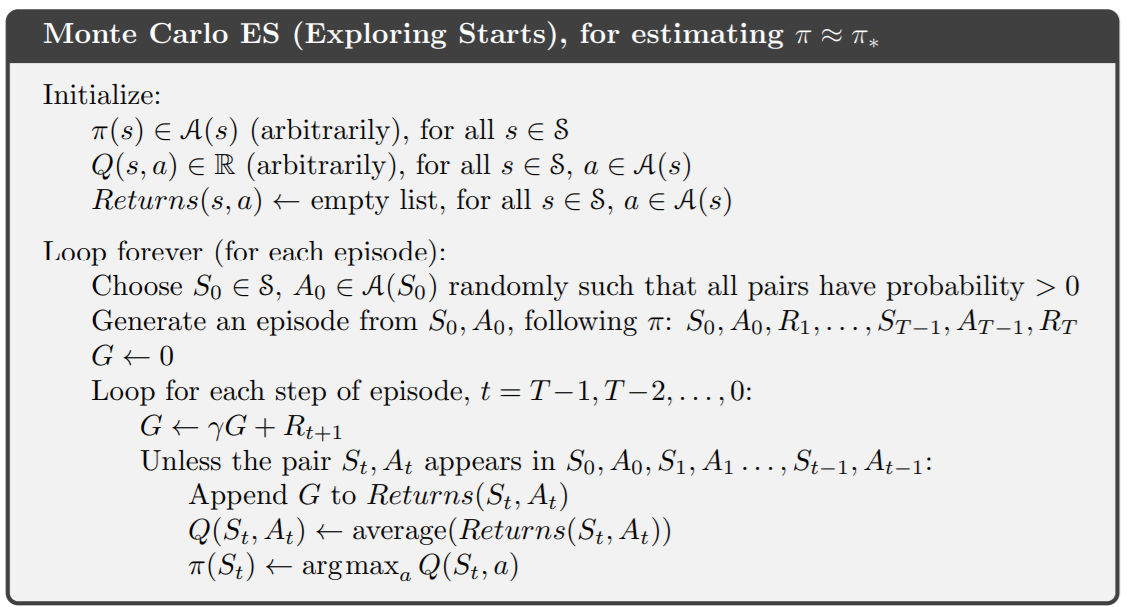

Where: 
<br>$S_{t}$ = The current state
<br>$A_{t}$ = The action taken in the current state
<br>$Q(S_{t},A_{t})$ = The current state-action value (Q-value) associated with the current state-action pair
<br>$\pi(s)$ = The current policy for a state $s$
<br>$R_{t+1}$ = The reward received from taking the action in the current state
<br>$\gamma$ = The discount rate to use in discounting returns (the weight placed on future rewards)
<br>$G$ = The total sum of discounted returns for an episode (respective of where in the episode the loop is currently in)

ES Monte Carlo randomizes the initial state and action of every episode with each state-action pair given equal probability of being the initial state-action pair. This allows  all state-action pairs to be visited infinitely often (assuming you are running an infinite number of episodes). Since every state-action pair is visited equally often by virtue of random initialization, we know that every state-action pair's Q value will be approximated equally well, with accuracy only being dictated by the number of episodes you decide to run. Since we can rest easy knowing that every state-action pair's Q value will be sufficiently approximated, we can use a hard policy to deterministically choose the action resulting in the highest Q value. If it is not the true optimal action, it will only be a matter of more episodes before the optimal action is taken in that state enough times for its Q value to be approximated correctly and inch above the suboptimal action. This method works very well for finite state-action spaces that are sufficiently small and discrete.

This algorithm is what Sutton and Barto used to solve blackjack since it had a sufficiently small state-action space (200 states and 2 actions = 400 state-action pairs, more on what these states are later). Their results are below:

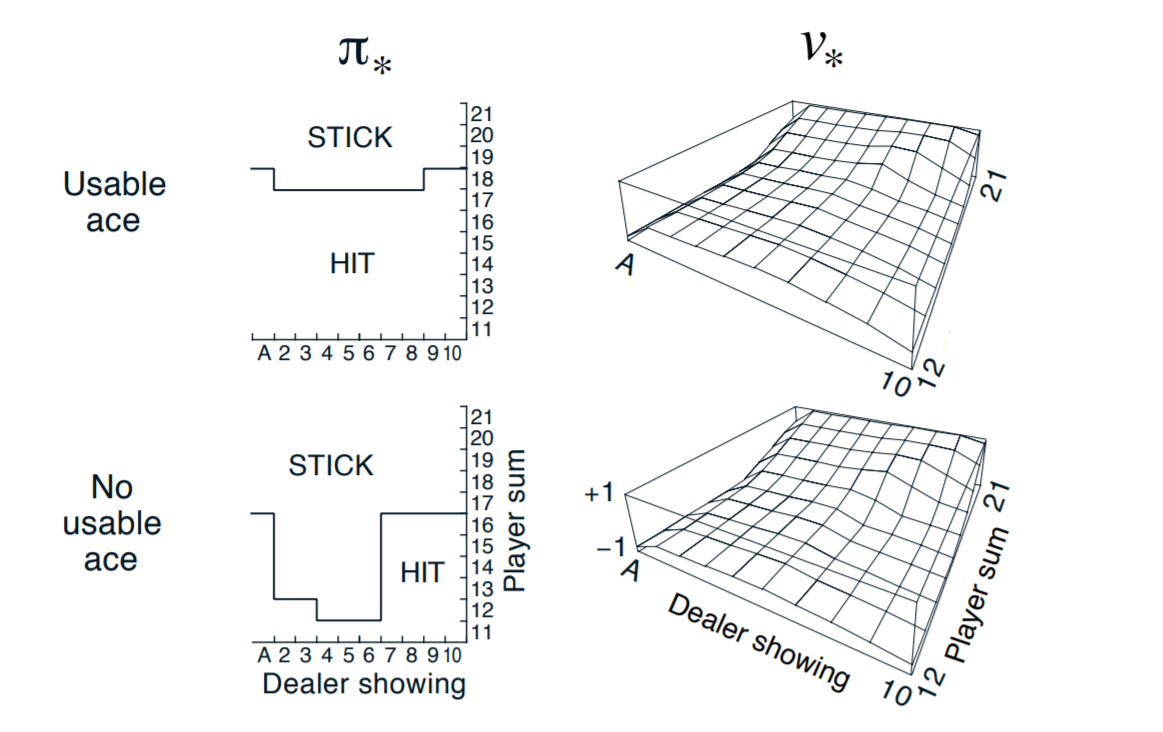

Which is indeed what the optimal strategy for blackjack is, except for the fact that Sutton and Barto's model recommends hitting on a soft 18 (a *soft total* is when there is an ace being treated as an 11 in the hand) when a dealer's showing an ace, whereas in Edward Thorp's 1966 book [Beat The Dealer: A Winning Strategy for the Game of Twenty-One](https://www.amazon.com/Beat-Dealer-Winning-Strategy-Twenty-One/dp/0394703103/ref=sr_1_1?dchild=1&keywords=beat+the+dealer&qid=1634019554&sr=8-1) it says to stand rather than hit. Sutton and Barto say the following regarding their output:

**_"This policy is the same as the “basic” strategy of Thorp (1966) with the
sole exception of the leftmost notch in the policy for a usable ace, which is not present
in Thorp’s strategy. We are uncertain of the reason for this discrepancy, but confident
that what is shown here is indeed the optimal policy for the version of blackjack we have
described."_**

### Exploration vs. Exploitation

ES Monte Carlo is a robust method for smaller problems with sufficiently small state-action spaces, however in most cases where state-action spaces are very large, ES will simply not do. The luxury that ES grants us is that we are guaranteed every state-action pair's number of visits will grow uniformly with each other with the number of episodes we run, allowing us to use a hard policy like above. But if the state-action space is too large, we need another way to explore other state-action pairs that are not currently optimal through the action selection process of the policy.

One of the difficulties in constructing these types of algorithms is visiting other sub-optimal state-action pairs enough such that the agent can sufficiently approximate their Q-values. If the rule for action selection is to simply take the currently approximated optimal action every single time like a hard policy, sub-optimal state-action pairs will not be visited enough to sufficiently approximate their Q-values, which will challenge the optimality of the so-called "optimal policy" arrived at by this action selection rule. On the other hand, choosing an action _at random_ every single time can avoid this, but will significantly slow down convergence to a solution.

The canonical and arguably most simple way to address this is to establish a parameter ε as an "exploration rate". Meaning, at each state, the agent will select the optimal action with probability $1-\epsilon$ and will select an action at random with probability $\epsilon$. This will allow sufficient exploration of sub-optimal policies over enough episodes for better approximation of the Q-table and thus more confidence in the optimality of the optimal policy. This action selection rule is known as the "ε-greedy" rule. The algorithm for **ε-greedy Monte Carlo** is below:

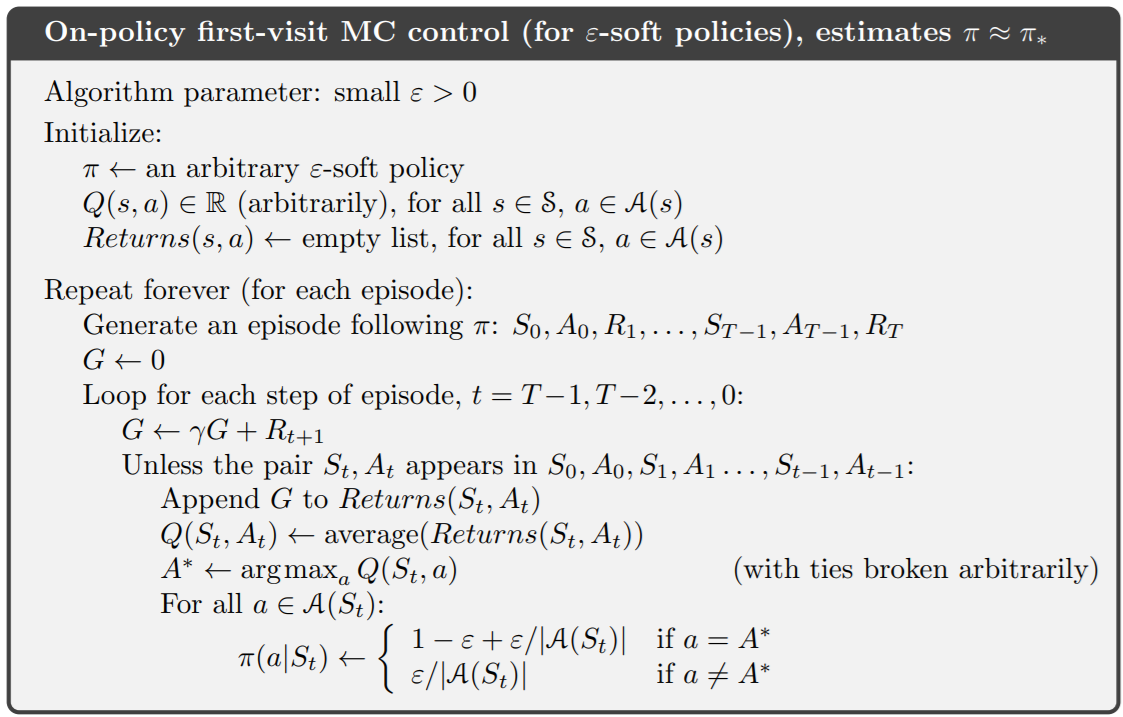

Note that $\pi$ is now a probability density function for a given state $s$ that gives the probability the agent will choose an action $a$ given a state.

### The Policy Improvement Theorem

In plain english, all this may seem very intuitive that improvement of the policy will occur. However, you don't need to take my word for it, there is rigorous math behind the general iterative strategies used in reinforcement learning that proves that the policies improve with each iteration. One such theorem is the **Policy Improvement Theorem**, the result of which I will summarize below to establish credibility to the ε-greedy Monte Carlo algorithm presented above.

#### Value Functions

Before jumping into the theorem, first I will formalize what we mean by *state value function* **$v_π(s)$** and *state-action value function* **$q_π(s,a)$**

What these functions essentially do is tell us how desirable it is to be in that state (or take a particular action in a given state). The metric by which desirability is determined is the expected future return:

\begin{align}
v_π(s) \;&\dot{=}\; \mathbb{E}_π\left[G_t\;|\;S_t=s\right] \;=\; \mathbb{E}_π\left[\sum\limits_{k=0}^{\infty}\gamma^kR_{t+k+1}\;|\;S_t=s\right] \\
q_π(s,a) \;&\dot{=}\; \mathbb{E}_π\left[G_t\;|\;S_t=s,\; A_t=a\right] \;=\; \mathbb{E}_π\left[\sum\limits_{k=0}^{\infty}\gamma^kR_{t+k+1}\;|\;S_t=s,\; A_t=a\right]
\end{align}


where $\mathbb{E}_π[\cdot]$ denotes the expected value of a random variable given that the agent follows policy $π$, $t$ is any time step, $R$ is the reward earned, and $\gamma$ is the discount factor. 

The two functions are connected in the sense that $q_π(s,a)$, the state-action value function under policy $π$ for a particular action $a$ taken in state $s$, is simply the reward obtained from taking action $a$ in state $S_t$ plus the expected future return from being in the following state $S_{t+1}$:

<center><br>
$q_π(s,a) \;\dot{=}\; \mathbb{E}\left[R_{t+1}+\gamma v_π(S_{t+1})\;|\;S_t=s,\; A_t=a\right]$
</center>

We want to use these value functions to structure our search for the optimal policy by finding the optimal value functions $v_*$ and $q_*$. The way in which we iterate twoards these optimal value functions is where the algorithms of reinforcement learning come in to play, however the way in which we know any particular value function is optimal is if it satisfies the **Bellman Optimality Equations**:

<br>
\begin{align}
v_*(s) \;&=\; \underset{a}{\max}\mathbb{E}\left[R_{t+1}+\gamma v_π(S_{t+1})\;|\;S_t=s,\; A_t=a\right] \\
&=\; \underset{a}{\max}\sum\limits_{s',r}p(s',r|s,a)\left[ r + \gamma v_*(s')\right]
\end{align}

<center>or</center>

\begin{align}
q_*(s,a) \;&=\; \mathbb{E}\left[R_{t+1}+\gamma \underset{a'}{\max}q_*(S_{t+1},\;a')\;|\;S_t=s,\; A_t=a\right] \\
&=\; \sum\limits_{s',r}p(s',r|s,a)\left[ r + \gamma \underset{a'}{\max}q_*(s',\;a')\right]
\end{align}

where $s'$ denotes a state that is not $s$, $a'$ is the action taken in state $s'$, $r$ is the reward associated with taking action $a$ in state $s$ and arriving in state $s'$, and $p(s',r|s,a)$ is the probability of obtaining the reward $r$ and arriving in state $s'$ after taking action $a$ in state $s$

#### Policy Improvement for ε-greedy Monte Carlo

If we let $π$ and $π'$ be two different policies, we can define $q_π(s,π'(s))$ to be:

<center><br>
$q_π(s,π'(s)) \;=\; \mathbb{E}\left[R_{t+1}+\gamma v_π(S_{t+1})\;|\;S_t=s,\; A_t=π'(s)\right]$
</center>

**This equation describes $q_π(s,π'(s))$ to be the state-action value associated with following policy $π$ up to that state, then following policy $π$ afterwards.** 

The **Policy Improvement Theorem** states that if:

<center><br>
$q_π(s,π'(s)) \;\ge\; v_π(s)$
</center>

for **EVERY** state $s$, then $π'$ is as good as (with strict equality $=$) or better than (with strict inequality $>$) $π$

Turning back to ε-greedy Monte Carlo, we can prove that any ε-greedy policy $π'$ with respect to $q_π$ will be an improvement over any other policy $π$:

<br>
\begin{align}
q_π(s,π'(s)) \;&=\; \sum\limits_{a}π'(a|s)\;q_π(s,a) \\\\
&=\; \frac{ε}{\mathcal{A}(s)}\sum\limits_{a}q_π(s,a) \;+\; (1-ε)\underset{a}{\max}q_π(s,a) \\\\
&\ge\; \frac{ε}{\mathcal{A}(s)}\sum\limits_{a}q_π(s,a) \;+\; (1-ε)\sum\limits_{a}\frac{π(a|s)-\;\frac{ε}{\mathcal{A}(s)}}{1-ε}q_π(s,a) \\\\
&=\; \frac{ε}{\mathcal{A}(s)}\sum\limits_{a}q_π(s,a) \;-\; \frac{ε}{\mathcal{A}(s)}\sum\limits_{a}q_π(s,a) \;+\; \sum\limits_{a}π(a|s)\;q_π(s,a) \\\\
&=\; \sum\limits_{a}π(a|s)\;q_π(s,a) \\\\
&=\; v_π(s)
\end{align}
<br>

The first two equations establish the computation of $q_π(s,π'(s))$ by its definition, which is the weighted average of all the Q values for a particular state's actions, weighted by the probabilities assigned to them by the ε-greedy policy $π'$. The inequality on the third line states that if instead of only assigning the max possible Q value the probability $(1-ε)$, we replace the max Q value with some weighted average of all actions with nonnegative weights summing to 1, it must be less than or equal to the largest number averaged in the previous line. After separating the terms to allow for additive cancellation, we are left with the state value function with respect to the general soft policy $π$, which is indeed less than or equal to $q_π(s,π'(s))$. Since this is true for all states $s$, the Policy Improvement Theorem confirms that the ε-greedy policy $π'$ will be an improvement over $π$ with each iteration.

### Blackjack

Since Sutton and Barto already solved Blackjack using ES Monte Carlo, I will be attempting to get the same result using ε-greedy Monte Carlo. The setup will be the following:

>1) Dealer will stand on soft and hard 17 or higher

>2) Each time a card is drawn from the deck it is immediately replaced, so card counting does not apply

>3) If the player wins a hand by having a greater sum than the dealer or the dealer busting, a reward of +1 is assigned. If the player loses through having a lower sum than the dealer or the player busting, a penalty of -1 is assigned. Any other situation (even in the interim steps within the hand before the player stands or busts) receives a reward of 0

>4) Only the first visit of a state-action pair within the episode will warrant the update of its Q value

>5) States will made up of a combination of 3 elements: the player's sum (12-21: 10 possible values), the dealer's initial card (2-11: 10 possible values), and whether or not the player holds a useable ace (True/False: 2 possible values)

>6) There will be 2 actions: player hits (1) or player stands (0)

>7) The Q table representing the running expected future returns for each state-action pair will therefore be 10x10x2x2 (200 states and 2 actions = 400 state-action pairs)

>8) Although the algorithm above keeps a list of returns obtained in each episode and averages them to obtain the Q value, I will be keeping a running total of returns and a running total number of first visits for each state-action pair and taking the quotient of the two to reduce the memory requirement needed (using the former method require more memory the more episodes you run)

The trick will be setting a small enough $ε$ such that the policy will closely resemble an argmax hard policy, but setting the number of episodes high enough such that all the state-action pairs will be visited enough times for proper approximation. The code and results are below:

In [1]:
import numpy as np
import random as rnd
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')

# creating object that will represent the deck to be drawn from
deck = np.tile(np.append(np.arange(1,11), np.tile(10,3)), 4)

# parameters and objects specific to Monte Carlo RL
gamma = 1
π = np.ones(shape = (10,10,2,2)) * 0.5
a_space = np.array([0,1])
sa_counter = np.zeros(shape = (10,10,2,2))
sa_returns = np.zeros(shape = (10,10,2,2))
Q = np.zeros(shape = (10,10,2,2))
ε = .005

# number of episodes to run
episodes = 200000000

# loop through episodes
for e in tqdm(range(episodes)):

    # start of hand
    dealer_hand = np.array(rnd.choice(deck)) # drawing a card for the dealer
    d_ace_in_hand = dealer_hand[dealer_hand == 1].size > 0 # checking if the dealer drew an ace
    d_useable_ace = d_ace_in_hand # if the dealer drew an ace, it will be treated as an 11
    
    if d_useable_ace:
        dealer_hand = np.where(dealer_hand == 1, 11, dealer_hand) # convert 1 to 11
        
    dealer_sum = dealer_hand.sum()
    
    player_hand = np.array(rnd.choices(deck, k=2)) # drawing 2 cards for the player
    p_ace_in_hand = player_hand[player_hand == 1].size > 0 # checking if the player drew any aces
    p_useable_ace = p_ace_in_hand and player_hand.sum() <= 21 # whether the player has a useable ace
    
    if p_useable_ace:
        if player_hand[player_hand == 1].size == 1:
            player_hand = np.where(player_hand == 1, 11, player_hand) # convert 1 to 11
        else:
            # if the player has more than 1 ace in hand, assign one of them a value of 11
            rnd_ace_index = rnd.choice(np.argwhere(player_hand == 1))[0]
            player_hand[rnd_ace_index] = 11
        
    player_sum = player_hand.sum()
    
    # only want to train agent on player sums greater than 11, so get it to an initial state where player sum is >11
    while player_sum < 12:
        next_card = rnd.choice(deck)
        if next_card == 1:
            p_ace_in_hand = True
            if player_sum + 11 <= 21:
                next_card = 11
                p_useable_ace = True
        player_hand = np.append(player_hand,next_card)
        player_sum += next_card
            
    # initialize flags indicating whether player or dealer busted
    p_bust = False
    d_bust = False
    
    # choosing initial action according to randomized initial policy
    a = np.random.choice(a_space, p = π[player_sum - 12][dealer_sum - 2][int(p_useable_ace)])
    
    # creating lists that will record state-action history throughout each episode and their rewards
    episode_hist = [(player_sum, dealer_sum, p_useable_ace, a)]
    reward_hist = []
    
    # logic for when the player chooses to hit (this loop will run until the action selected at the end is a 0 (Stand))
    while a == 1:
        next_card = rnd.choice(deck)
        if next_card == 1:
            p_ace_in_hand = True
            if player_sum + 11 <= 21:
                next_card = 11
                p_useable_ace = True
        player_hand = np.append(player_hand, next_card)
        player_sum += next_card
        
        # player busts if the sum is >21 and there isn't an ace in hand or the ace can't be treated as an 11
        if player_sum > 21 and (not p_ace_in_hand or (p_ace_in_hand and not p_useable_ace)):
            p_bust = True
            R = -1
            reward_hist = np.append(reward_hist, R)
            break
        # if the player sum is >21 but there is an ace being treated as an 11, downgrade it to a 1
        elif player_sum > 21 and p_useable_ace:
            player_hand = np.where(player_hand == 11, 1, player_hand) # convert 11 to 1
            p_useable_ace = False
            player_sum = player_hand.sum()
        R = 0
        reward_hist = np.append(reward_hist, R)
        
        # choose next action according to current policy (if it's a 0, then the while loop breaks)
        a = np.random.choice(a_space, p = π[player_sum - 12][dealer_sum - 2][int(p_useable_ace)])
        episode_hist.append((player_sum, dealer_sum, p_useable_ace, a))
    
    if not p_bust: # if the player stands, it's the dealer's turn
        while dealer_sum < 17: # dealer will stand on 17 and higher
            next_card = rnd.choice(deck)
            if next_card == 1:
                d_ace_in_hand = True
                if dealer_sum + 11 <= 21:
                    next_card = 11
                    d_useable_ace = True
            dealer_hand = np.append(dealer_hand, next_card)
            dealer_sum += next_card
            if dealer_sum > 21 and (not d_ace_in_hand or (d_ace_in_hand and not d_useable_ace)):
                d_bust = True
                R = 1
                reward_hist = np.append(reward_hist, R)
                break
            elif dealer_sum > 21 and d_useable_ace:
                dealer_hand = np.where(dealer_hand == 11, 1, dealer_hand) # convert 11 to 1
                d_useable_ace = False
                dealer_sum = dealer_hand.sum()
                
        # if neither the player nor dealer bust, then compare sums to determine winner
        if not d_bust:
            if player_sum > dealer_sum:
                R = 1
                reward_hist = np.append(reward_hist, R)
            elif player_sum < dealer_sum:
                R = -1
                reward_hist = np.append(reward_hist, R)
            else:
                R = 0
                reward_hist = np.append(reward_hist, R)
                
    assert len(episode_hist) == len(reward_hist)
    
    # updating the policy
    G = 0 # initialize return value
    for t in reversed(range(len(episode_hist))): # work backwards through episode
        G = gamma * G + reward_hist[t] # add reward to discounted returns
        
        # converting state components and action to integers that represent their index in the numpy array
        p_sum_index = episode_hist[t][0] - 12
        d_sum_index = episode_hist[t][1] - 2
        ua_index = int(episode_hist[t][2])
        a_index = episode_hist[t][3]
        
        # update Q value for a state-action pair if it is its first time occurring in episode
        if episode_hist[t] not in episode_hist[:t]:
            sa_returns[p_sum_index][d_sum_index][ua_index][a_index] += G
            sa_counter[p_sum_index][d_sum_index][ua_index][a_index] += 1
            
            # Q value for state-action pair is average of returns over all episodes so far
            Q[p_sum_index][d_sum_index][ua_index][a_index] = (sa_returns[p_sum_index][d_sum_index][ua_index][a_index]/
                                                              sa_counter[p_sum_index][d_sum_index][ua_index][a_index])
            
            # update policy according to ε-greedy update rule
            a_star = np.argmax(Q[p_sum_index][d_sum_index][ua_index])
            π[p_sum_index][d_sum_index][ua_index] = ε/len(a_space)
            π[p_sum_index][d_sum_index][ua_index][a_star] = 1 - ε + ε/len(a_space)

# prevents progress bar from printing to new line for every iteration upon next run
while len(tqdm._instances) > 0:
    tqdm._instances.pop().close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000000/200000000 [5:03:44<00:00, 10974.43it/s]


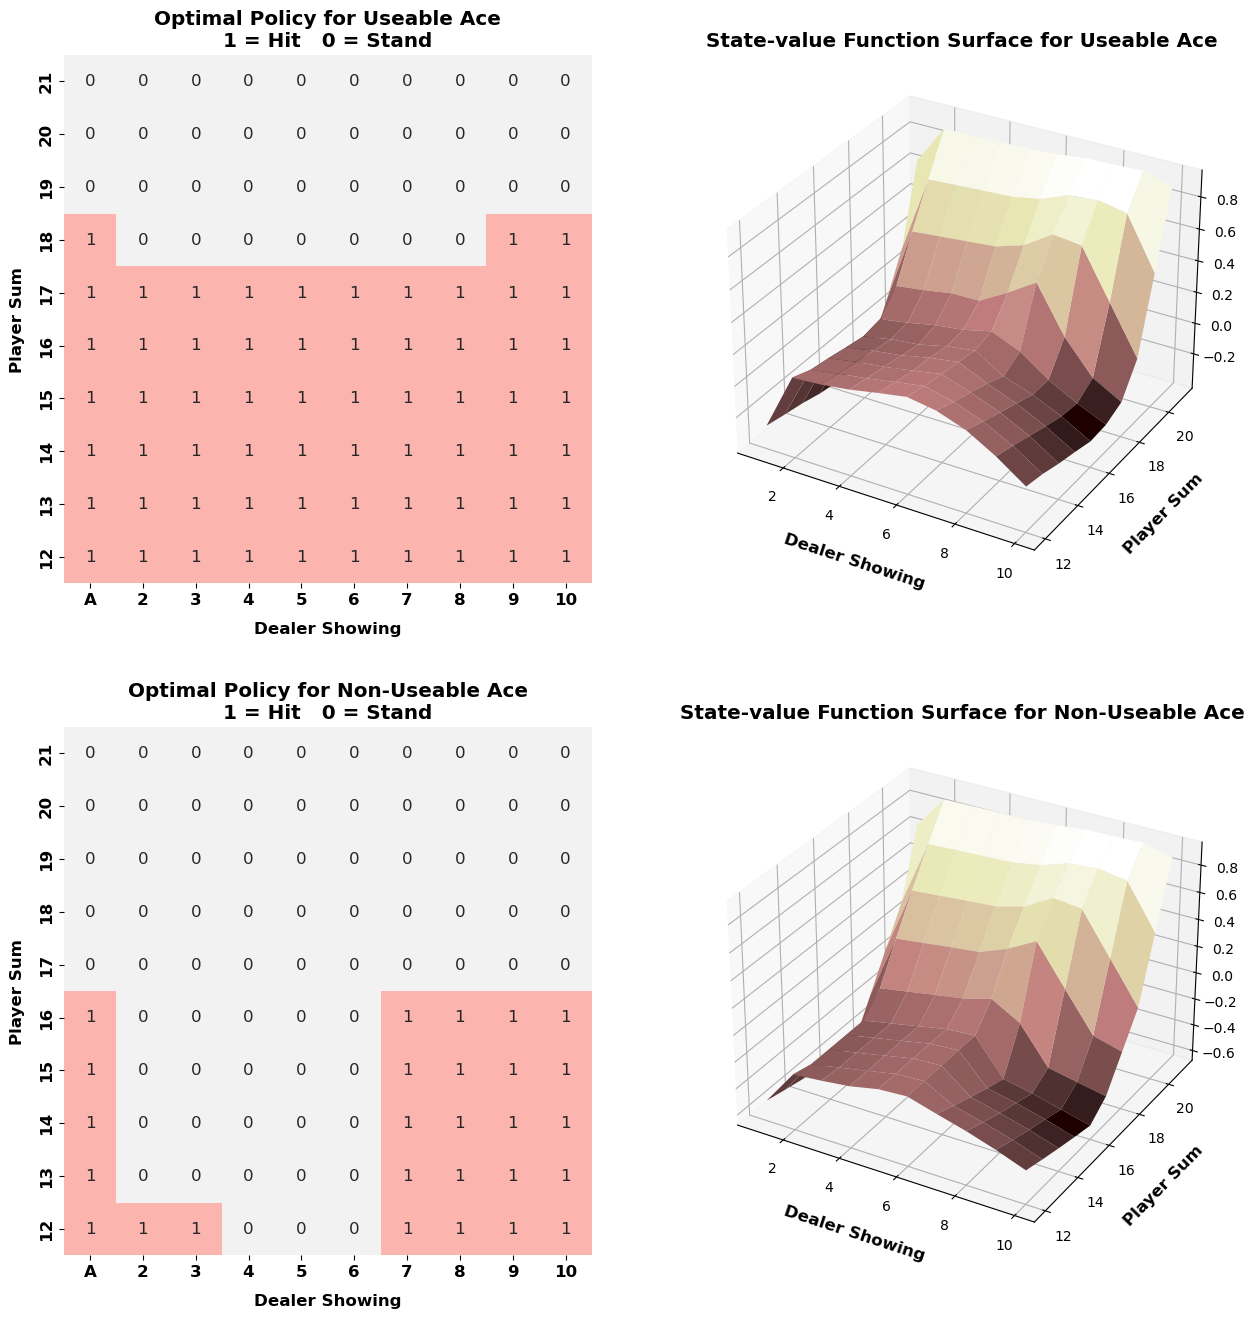

In [2]:
fig = plt.figure(figsize=(15,16))
cmap='Pastel1_r'
cmap2='pink'

# create data for plotting
ua_policy = np.round(π[:,:,1,1])
nua_policy = np.round(π[:,:,0,1])
ua_v = (sa_returns[:,:,1,0] + sa_returns[:,:,1,1])/(sa_counter[:,:,1,0] + sa_counter[:,:,1,1])
nua_v = (sa_returns[:,:,0,0] + sa_returns[:,:,0,1])/(sa_counter[:,:,0,0] + sa_counter[:,:,0,1])

# get column that represents dealer showing ace on left side to match sutton and barto plots
ua_policy = ua_policy[:,[9,0,1,2,3,4,5,6,7,8]]
nua_policy = nua_policy[:,[9,0,1,2,3,4,5,6,7,8]]
ua_v = ua_v[:,[9,0,1,2,3,4,5,6,7,8]]
nua_v = nua_v[:,[9,0,1,2,3,4,5,6,7,8]]

# reverse order of player sum
ua_policy = ua_policy[list(reversed(range(10))),:]
nua_policy = nua_policy[list(reversed(range(10))),:]
ua_v = ua_v[list(reversed(range(10))),:]
nua_v = nua_v[list(reversed(range(10))),:]

# convert numpy arrays to pandas dataframes
ua_policy = pd.DataFrame(ua_policy, index = np.arange(12,22)[::-1], columns = ['A',2,3,4,5,6,7,8,9,10])
nua_policy = pd.DataFrame(nua_policy, index = np.arange(12,22)[::-1], columns = ['A',2,3,4,5,6,7,8,9,10])
ua_v = pd.DataFrame(ua_v, index = np.arange(12,22)[::-1], columns = [1,2,3,4,5,6,7,8,9,10])
nua_v = pd.DataFrame(nua_v, index = np.arange(12,22)[::-1], columns = [1,2,3,4,5,6,7,8,9,10])

# plotting useable ace policy
ax1 = fig.add_subplot(221)
sns.heatmap(ua_policy, ax=ax1, annot=True, annot_kws={'fontsize':'large'}, cmap=cmap, cbar=False, square=True)
ax1.set_title('Optimal Policy for Useable Ace\n1 = Hit   0 = Stand', fontsize='x-large', fontweight='bold')
plt.xlabel('Dealer Showing', fontweight='bold', fontsize='large', labelpad=10)
plt.ylabel('Player Sum', fontweight='bold', fontsize='large', labelpad=10)
plt.xticks(fontsize='large', fontweight='bold') 
plt.yticks(fontsize='large', fontweight='bold') 

# plotting non-useable ace policy
ax2 = fig.add_subplot(223)
sns.heatmap(nua_policy, ax=ax2, annot=True, annot_kws={'fontsize':'large'}, cmap=cmap, cbar=False, square=True)
ax2.set_title('Optimal Policy for Non-Useable Ace\n1 = Hit   0 = Stand', fontsize='x-large', fontweight='bold')
plt.xlabel('Dealer Showing', fontweight='bold', fontsize='large', labelpad=10)
plt.ylabel('Player Sum', fontweight='bold', fontsize='large', labelpad=10)
plt.xticks(fontsize='large', fontweight='bold')
plt.yticks(fontsize='large', fontweight='bold') 

# plotting useable ace state-value function surface
ax3 = fig.add_subplot(222, projection='3d')
X, Y = np.meshgrid(ua_v.columns.values, ua_v.index.values)
ax3.plot_surface(X,Y, ua_v, cmap=cmap2)
ax3.set_title('State-value Function Surface for Useable Ace', fontsize='x-large', fontweight='bold')
plt.xlabel('Dealer Showing', fontweight='bold', fontsize='large', labelpad=10)
plt.ylabel('Player Sum', fontweight='bold', fontsize='large', labelpad=10)

# plotting non-useable ace state-value function surface
ax4 = fig.add_subplot(224, projection='3d')
X, Y = np.meshgrid(nua_v.columns.values, nua_v.index.values)
ax4.plot_surface(X,Y, nua_v, cmap=cmap2)
ax4.set_title('State-value Function Surface for Non-Useable Ace', fontsize='x-large', fontweight='bold')
plt.xlabel('Dealer Showing', fontweight='bold', fontsize='large', labelpad=10)
plt.ylabel('Player Sum', fontweight='bold', fontsize='large', labelpad=10)

plt.show()

Compared to Sutton and Barto's results, everything looks good!:

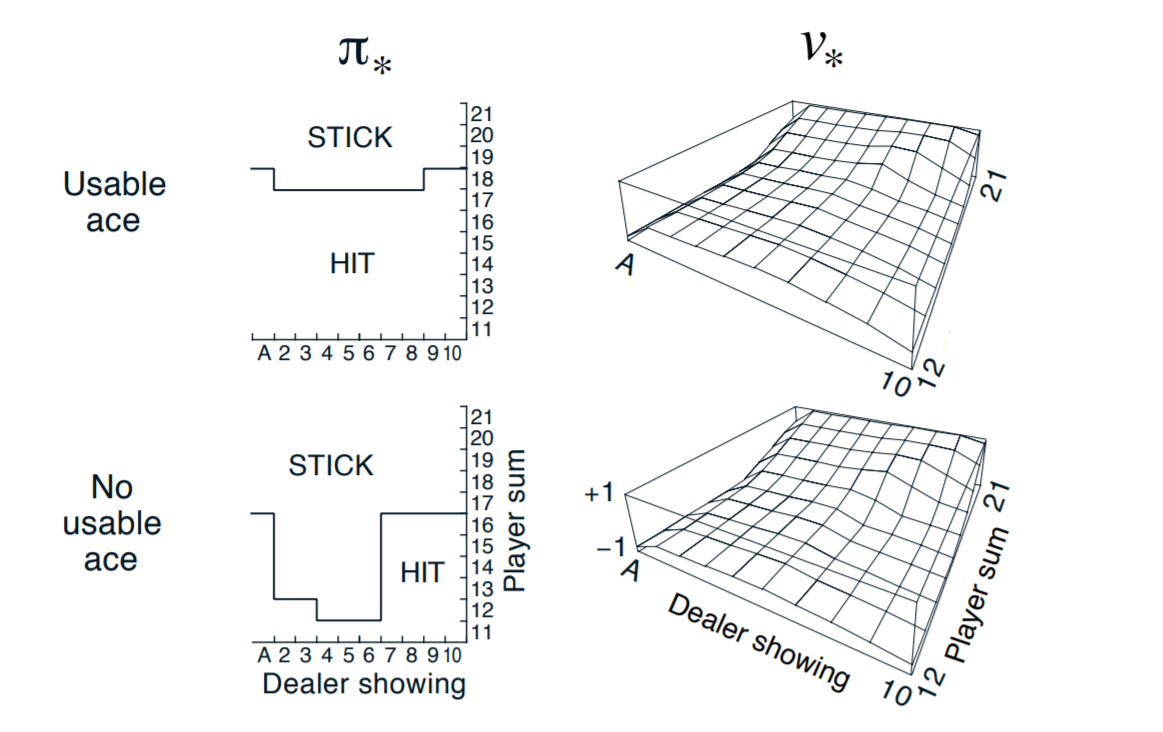